# XG Boosted Trees for heartProblem prediction

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats
from statsmodels.tsa import stattools
from sklearn import preprocessing
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
feats = np.load('heartCondition_feats_15_aligned.npy')
labels = np.load('../processed_datasets/heartCondition_y_15_aligned.npy')
ids = np.load('../processed_datasets/heartCondition_ids_15_aligned.npy')
feats.shape, labels.shape, ids.shape

((862177, 14, 15), (862177,), (862177,))

In [ ]:
#Optional, select only accel and gyro
feats = feats[:, :, [0, 1, 2, 4, 5, 6]]
feats.shape

In [3]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

#Flatten the features
feats = feats.reshape((feats.shape[0], -1))

#Remove nans
valid_idxs = ~np.isnan(feats).any(axis=1)
feats = feats[valid_idxs]
labels = labels[valid_idxs]
ids = ids[valid_idxs]

print(feats.shape, labels.shape)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels, train_ids, test_ids = train_test_split(feats, labels, ids, test_size = 0.1, random_state = 42, shuffle = False)
train_features, val_features, train_labels, val_labels, train_ids, val_ids = train_test_split(train_features, train_labels, train_ids, test_size = 2/9, random_state = 42, shuffle = False)
#Scale the features
train_features_scaled = preprocessing.scale(train_features)
test_features_scaled = preprocessing.scale(test_features)
val_features_scaled = preprocessing.scale(val_features)


print('Training Features Shape:', train_features_scaled.shape)
print('Training Labels Shape:', train_labels.shape)
print('Val Features Shape:', val_features_scaled.shape)
print('Val Labels Shape:', val_labels.shape)
print('Testing Features Shape:', test_features_scaled.shape)
print('Testing Labels Shape:', test_labels.shape)

(859058, 210) (859058,)
Training Features Shape: (601340, 210)
Training Labels Shape: (601340,)
Val Features Shape: (171812, 210)
Val Labels Shape: (171812,)
Testing Features Shape: (85906, 210)
Testing Labels Shape: (85906,)


In [4]:
#Optional, balance the dataset
false_idx = np.nonzero(train_labels == False)[0]
true_idx = np.nonzero(train_labels)[0]
print(len(false_idx), len(true_idx))
num_to_take = min(len(false_idx), len(true_idx))

valid_idx = np.concatenate((false_idx[:num_to_take], true_idx[:num_to_take]))
np.random.shuffle(valid_idx)

train_features_scaled = train_features_scaled[valid_idx]
train_labels = train_labels[valid_idx]
train_ids = train_ids[valid_idx]
print(train_ids.shape)

566945 34395
(68790,)


In [5]:
# The baseline predictions are the train set averages
baseline_preds = np.zeros_like(train_labels) + np.mean(train_labels)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - train_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.5


In [7]:
# Import the model we are using
from xgboost import XGBRegressor
# Instantiate model
model = XGBRegressor(n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=0, reg_lambda=1, tree_method='gpu_exact')
model.fit(train_features_scaled, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='exact',
             verbosity=1)

In [8]:
# Use the model's predict method on the train data
predictions = model.predict(train_features_scaled)
acc = np.round(predictions) == train_labels
print('Train Accuracy:', np.mean(acc))

Train Accuracy: 0.812472743131269


Text(0.5, 1, 'Heart Problem Prediction Confusion Matrix')

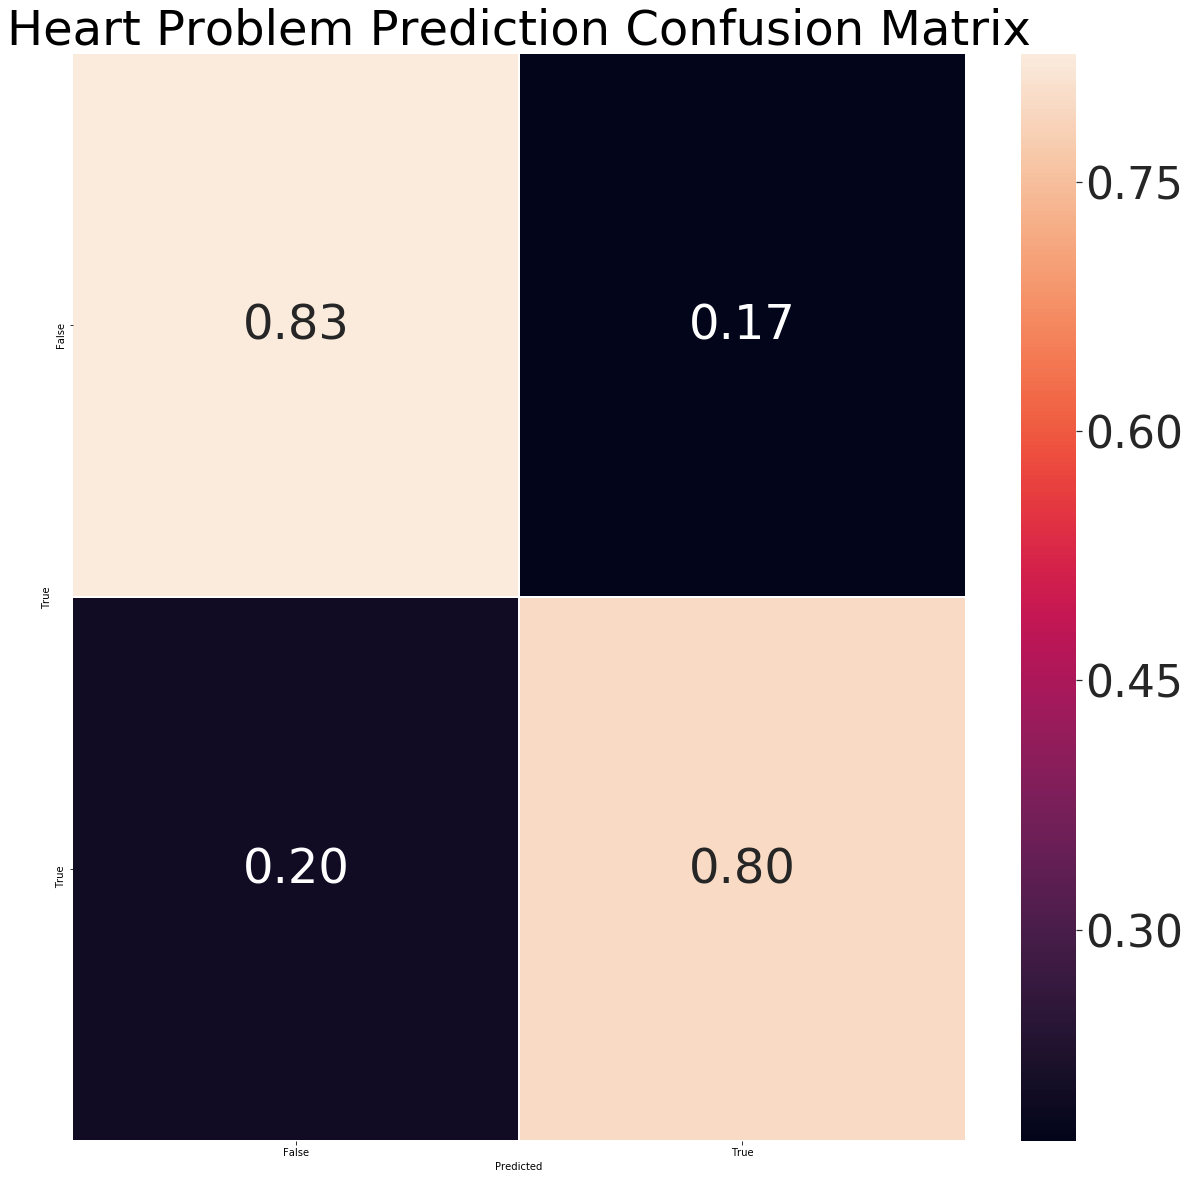

In [9]:
#Print confusion matrix
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((train_labels,predictions.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['False', 'True'],
            yticklabels = ['False', 'True'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Heart Problem Prediction Confusion Matrix')

In [10]:
# Use the model's predict method on the val data
predictions = model.predict(val_features_scaled)
acc = np.round(predictions) == val_labels
print('Test Accuracy:', np.mean(acc))

Test Accuracy: 0.3984354992666403


Text(0.5, 1, 'Heart Prediction Confusion Matrix')

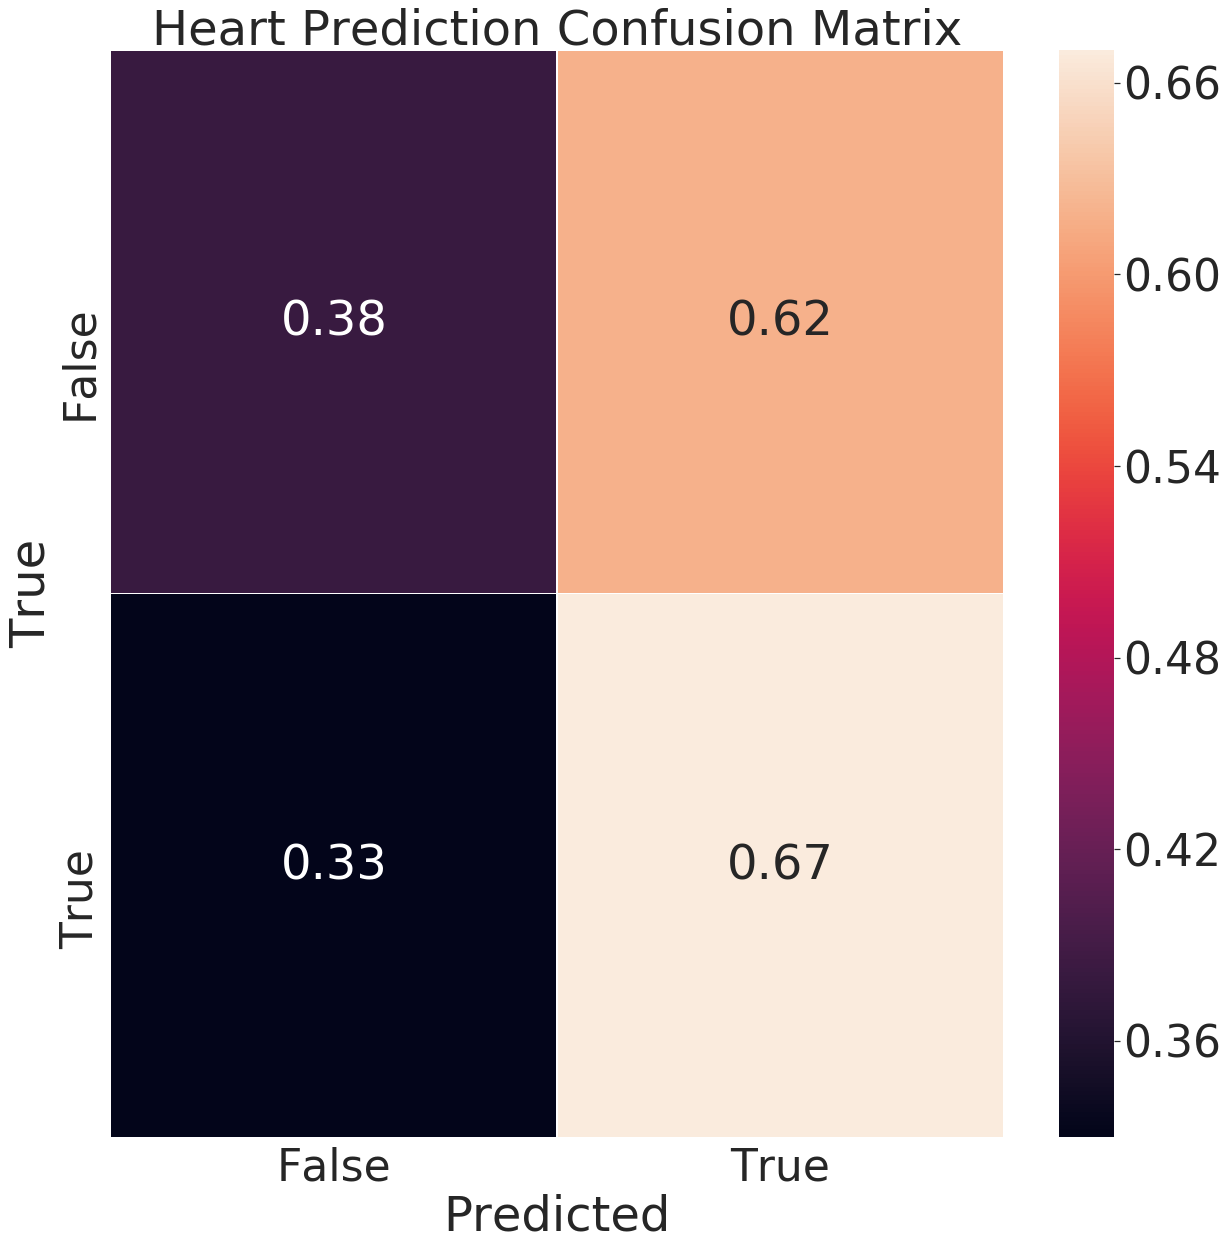

In [11]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((val_labels,predictions.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['False', 'True'],
            yticklabels = ['False', 'True'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Heart Prediction Confusion Matrix')

In [12]:
feature_list = np.arange(210)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                   14 Importance: 0.024108657613396645
Variable:                  152 Importance: 0.02301385998725891
Variable:                   23 Importance: 0.021715911105275154
Variable:                   67 Importance: 0.018715986981987953
Variable:                    7 Importance: 0.018479637801647186
Variable:                   27 Importance: 0.017703767865896225
Variable:                  156 Importance: 0.01762055605649948
Variable:                   47 Importance: 0.01741398312151432
Variable:                   71 Importance: 0.016760019585490227
Variable:                    9 Importance: 0.01662415638566017
Variable:                  162 Importance: 0.016331566497683525
Variable:                  158 Importance: 0.016043873503804207
Variable:                   63 Importance: 0.015495342202484608
Variable:                  167 Importance: 0.015488033182919025
Variable:                  150 Importance: 0.015119745396077633
Variable:                  166 Importance: 0

AUROC: 0.5368637954124581


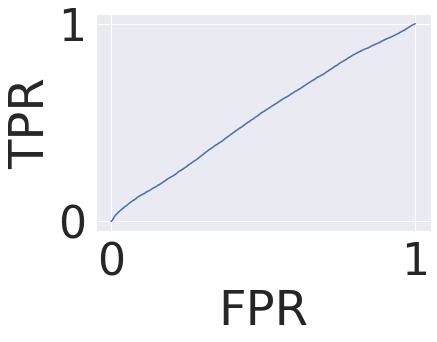

EER Threshold: 0.57171327 EER:  0.47359708349608465


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

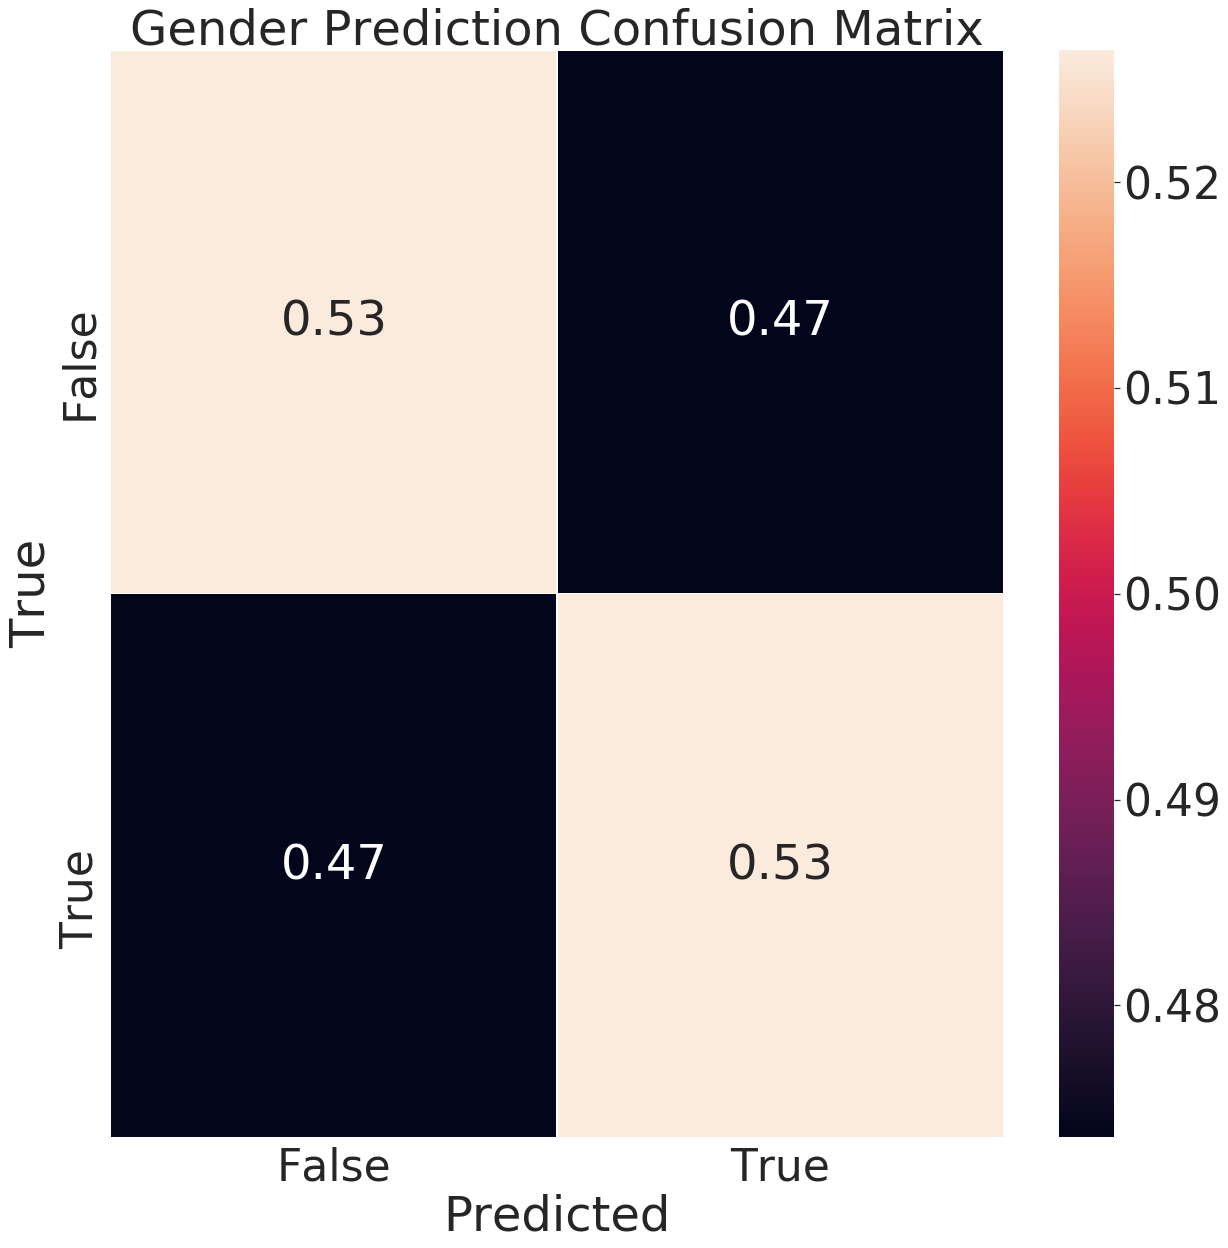

In [13]:
#ROC curve
from sklearn import metrics
y_score = model.predict(val_features_scaled)
fpr, tpr, threshs = metrics.roc_curve(val_labels, y_score)

print("AUROC: {}".format(metrics.roc_auc_score(val_labels, y_score)))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

fnr = 1 - tpr
eer_threshold = threshs[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER Threshold:", eer_threshold, "EER: ", EER)

fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((val_labels,y_score > eer_threshold)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['False', 'True'],
            yticklabels = ['False', 'True'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

# Userwise Accuracy

In [14]:
y_round = model.predict(test_features_scaled) > eer_threshold
thresh = 0.5
unique_ids = np.unique(test_ids)
print(f'There are {len(unique_ids)} unique ids in our test set.')

user_preds = []
user_trues = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(test_ids == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    temp = np.sum(y_round[usr_idxs])/len(usr_idxs)
    pred = temp > thresh
    true = y_round[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
    else:
        female_acc.append(true == pred)

There are 615 unique ids in our test set.


In [15]:
np.sum(overall_acc)/len(overall_acc), np.sum(female_acc)/len(female_acc), np.sum(male_acc)/len(male_acc)

(0.767479674796748, 0.8865248226950354, 0.5052083333333334)